In [62]:
import pandas as pd
from sqlalchemy import create_engine

# In die Datei const.py müssen die Zugangsdaten eingetragen werden
import const as c

In [2]:
engine = create_engine(
    f'postgresql://{c.pg_userid}:{c.pg_password}@{c.pg_host}/{c.pg_db}', 
    connect_args = {'options': '-c search_path=uadbkt,uccfraud', 'keepalives_idle': 120},
    pool_size=1, 
    max_overflow=0,
    execution_options={ 'isolation_level': 'AUTOCOMMIT' }
)

In [3]:
# engine.dispose()

## Datensätze


### AnzahlDS

In [8]:
sql="""
select count(*) as AnzahlDS from ccfraud2010;
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)

data_pdf

,anzahlds
0,16575073


### AnzahlDS pro Jahr, prozentualer Anteil pro Jahr

In [56]:
sql = """
select 
	extract(year from ts) jahr,
	count(*) anzahlDS,
	(count(*) / sum(count(*)) over ()) *100 anteile
from ccfraud2010 
group by extract(year from ts)"""

with engine.connect() as con:
     data_pdf = pd.read_sql_query(sql, con)
     data_pdf.jahr = data_pdf.jahr.astype('int32')
        
data_pdf

,jahr,anzahlds,anteile
0,2010,1491225,8.996793
1,2011,1570551,9.475379
2,2014,1672343,10.089506
3,2019,1723938,10.400787
4,2013,1650917,9.960240
5,2016,1708924,10.310205
6,2015,1701371,10.264637
7,2012,1610829,9.718383
8,2018,1721615,10.386772
9,2017,1723360,10.397300


### AnzahlDS Ok/Betrug, prozentualer Anteile 

In [61]:
sql = """
select
	is_fraud,
	count(*), 
	(count(*) / sum(count(*)) over ()) anteile
from ccfraud2010
group by is_fraud
"""

with engine.connect() as con:
     data_pdf = pd.read_sql_query(sql, con)
        
data_pdf

,is_fraud,count,anteile
0,No,16555087,0.998794
1,Yes,19986,0.001206


### AnzahlDS pro Land, Anteile pro Land

In [9]:
sql="""
select 
    case
        when length(mstate) = 2 then 'USA'
        else mstate
        end land,
        count(*) as anz_land,
        (count(*) / sum(count(*)) over ()) * 100 as anteile_land
from ccfraud2010 c 
group by land
order by anteile_land desc
limit 20
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    data_pdf.set_index('land', inplace = True)
    
data_pdf

,anz_land,anteile_land
land,,
USA,14479993,87.360056
None,1987649,11.991796
Mexico,33032,0.199287
Canada,13280,0.080120
Italy,7583,0.045749
United Kingdom,5662,0.034160
Germany,3614,0.021804
France,3583,0.021617
China,3372,0.020344


## Nutzer

### Anzahl Nutzer

In [10]:
sql = """
    select
        userid,
        count(*) anz_user
    from ccfraud2010
    group by userid 
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    data_pdf.set_index('userid', inplace = True)
    
data_pdf

,anz_user
userid,
0,11562
1,5661
2,26298
3,8823
4,9375
...,...
1995,11734
1996,10568
1997,11925


### min, max, avg Anzahl Transaktionen pro Nutzer

In [11]:
sql = """
select
    userid,
    max(amount),
    min(amount),
    avg(amount)
from ccfraud2010 
group by userid ;"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,userid,max,min,avg
0,0,1409.40,-499.0,80.384682
1,1,3750.60,-497.0,79.723461
2,2,1195.57,-495.0,33.054134
3,3,6820.20,-496.0,126.823747
4,4,3613.22,-500.0,96.752194
...,...,...,...,...
1637,1995,1791.31,-487.0,23.221213
1638,1996,1353.67,-500.0,40.320621
1639,1997,1243.24,-481.0,29.751038
1640,1998,1498.89,-500.0,58.931124


### min, max, avg User (Yen)

In [12]:
sql = """
with 
  a(userid, anz_transaktion) as (
    select userid,
           count(*) as anz_transaktion
    from ccfraud2010 c
    group by userid
  )
  
select userid, min(anz_transaktion) as "min",
       max(anz_transaktion) as "max",
       avg(anz_transaktion) as "avg"
from a
group by userid
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
data_pdf

,userid,min,max,avg
0,0,11562,11562,11562.0
1,1,5661,5661,5661.0
2,2,26298,26298,26298.0
3,3,8823,8823,8823.0
4,4,9375,9375,9375.0
...,...,...,...,...
1637,1995,11734,11734,11734.0
1638,1996,10568,10568,10568.0
1639,1997,11925,11925,11925.0
1640,1998,5665,5665,5665.0


### Histogramm Transaktionenanzahl pro Nutzer, Unterteilung 40 Bins

In [13]:
sql = """
    select 
    userid,
    count(*)
from ccfraud2010
group by userid 
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,userid,count
0,0,11562
1,1,5661
2,2,26298
3,3,8823
4,4,9375
...,...,...
1637,1995,11734
1638,1996,10568
1639,1997,11925
1640,1998,5665


<AxesSubplot: title={'center': 'Anzahl Transaktionen von Nutzern, 40 bins'}, ylabel='Frequency'>

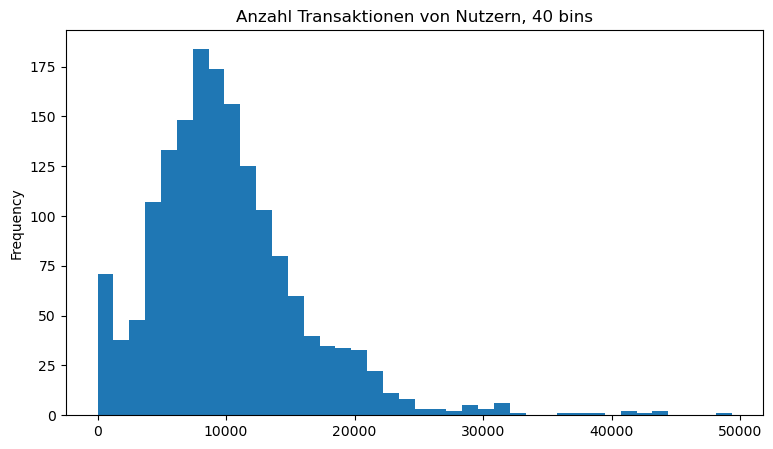

In [121]:
title = 'Anzahl Transaktionen von Nutzern, 40 bins'
data_pdf['count'].plot.hist(figsize=(9,5), bins= 40, title=title)

## Unternehmen

### Anzahl Unternehmen

In [14]:
sql = """
    select
        mname,
        count(*) anz_unternehmen
    from ccfraud2010
    group by mname
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,mname,anz_unternehmen
0,-9222899435637403521,66
1,-9222692221935167526,1
2,-9222439367252190791,4
3,-9222264855000293132,2
4,-9222232253446715869,2
...,...,...
85562,9222821118491815331,49
85563,9222874644865944349,10
85564,9222877122873253163,1844
85565,9222957302638210593,1


### min, max, avg number of transactions per country

In [15]:
sql = """
select
    mname,
    max(amount),
    min(amount),
    avg(amount)
from ccfraud2010 
group by mname ;"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,mname,max,min,avg
0,-9222899435637403521,31.87,9.73,21.354091
1,-9222692221935167526,144.74,144.74,144.740005
2,-9222439367252190791,204.96,53.81,95.750002
3,-9222264855000293132,84.81,21.27,53.039999
4,-9222232253446715869,6.84,6.03,6.435000
...,...,...,...,...
85562,9222821118491815331,240.21,46.31,116.048163
85563,9222874644865944349,17.83,10.35,14.919000
85564,9222877122873253163,143.51,0.19,35.868200
85565,9222957302638210593,83.14,83.14,83.139999


### min, max, avg Unternehmen (Yen)

In [16]:
sql = """
with 
  base1(unternehmen, anz_unternehmen) as (
      select mname,
             count(*) as anz_unternehmen
      from ccfraud2010 c
      group by mname
  )
  
select unternehmen as "unternehmen",
       anz_unternehmen as "anz_unternehmen"
from base1
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('anz_unternehmen', inplace = True)
data_pdf

,unternehmen
anz_unternehmen,
66,-9222899435637403521
1,-9222692221935167526
4,-9222439367252190791
2,-9222264855000293132
2,-9222232253446715869
...,...
49,9222821118491815331
10,9222874644865944349
1844,9222877122873253163


### Histogramm Transaktionenanzahl pro Unternehmen

#### Bis 10 Transaktionen

In [17]:
sql = """
    select
        mname,
        count(*)
    from ccfraud2010
    group by mname
    having count(*) <=10
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,mname,count
0,-9222692221935167526,1
1,-9222439367252190791,4
2,-9222264855000293132,2
3,-9222232253446715869,2
4,-9221703435869302066,1
...,...,...
57840,9222256728167807418,4
57841,9222343863901979949,3
57842,9222874644865944349,10
57843,9222957302638210593,1


<AxesSubplot: title={'center': 'Anzahl Transaktionen von Unternehmen, 10 bins'}, ylabel='Frequency'>

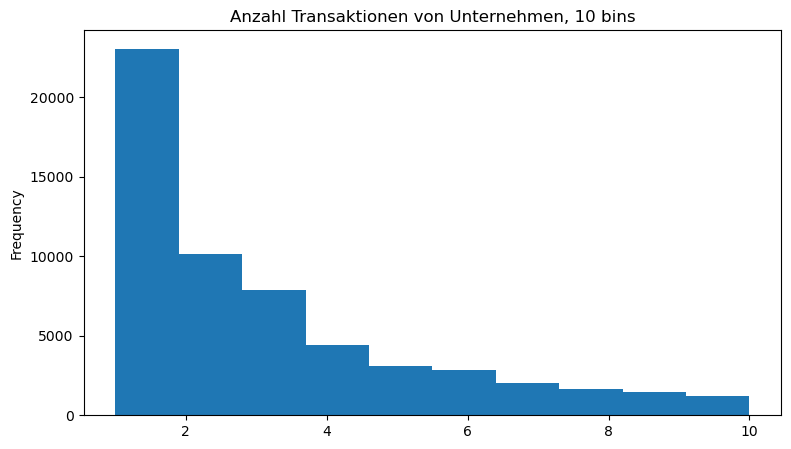

In [18]:
title = 'Anzahl Transaktionen von Unternehmen, 10 bins'
data_pdf['count'].plot.hist(figsize=(9,5), bins= 10, title=title)

#### Bis 100 Transaktionen

In [19]:
sql = """
    select
        mname,
        count(*)
    from ccfraud2010
    group by mname
    having count(*) <=100
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,mname,count
0,-9222899435637403521,66
1,-9222692221935167526,1
2,-9222439367252190791,4
3,-9222264855000293132,2
4,-9222232253446715869,2
...,...,...
76446,9222343863901979949,3
76447,9222821118491815331,49
76448,9222874644865944349,10
76449,9222957302638210593,1


<AxesSubplot: title={'center': 'Anzahl Transaktionen von Unternehmen, 100 bins'}, ylabel='Frequency'>

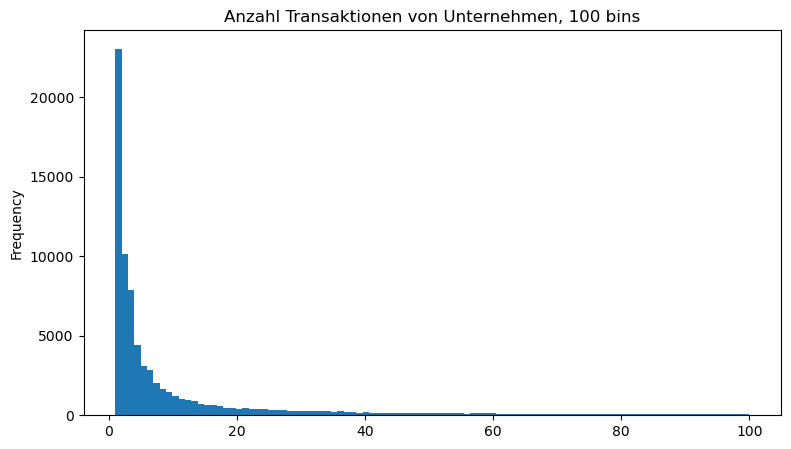

In [20]:
title = 'Anzahl Transaktionen von Unternehmen, 100 bins'
data_pdf['count'].plot.hist(figsize=(9,5), bins= 100, title=title)

#### Ab 100000 Transaktionen

In [21]:
sql = """
    select
        mname,
        count(*)
    from ccfraud2010
    group by mname
    having count(*) >100000
"""
with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql,con)
    
data_pdf

,mname,count
0,-6571010470072147219,396678
1,-6458444334611773637,123510
2,-6160036380778658394,197836
3,-5841929396161652653,197882
4,-5475680618560174533,287497
5,-5467922351692495955,257152
6,-5162038175624867091,441558
7,-4500542936415012428,123342
8,-4334232547381218591,198991
9,-4282466774399734331,734404


<AxesSubplot: title={'center': 'Anzahl Transaktionen von Unternehmen, 7 bins'}, ylabel='Frequency'>

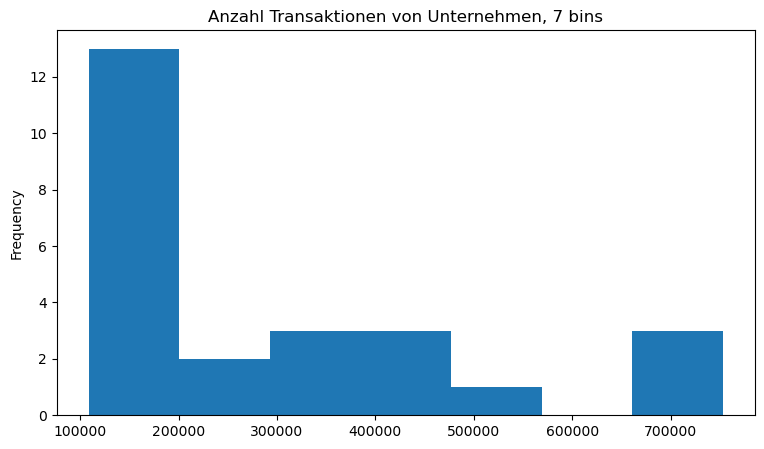

In [22]:
title = 'Anzahl Transaktionen von Unternehmen, 7 bins'
data_pdf['count'].plot.hist(figsize=(9,5), bins= 7, title=title)

# Analysieren den Betrugsanteil 

## Analysieren den Betrugsanteil pro Jahr

In [23]:
sql ="""
with
  base(jahr, is_fraud) as (
    select 
      extract(year from ts),
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(jahr, anz_trx, ant_ok, ant_fraud) as (
    select 
      jahr,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by jahr
  ),
  ratio(jahr, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      jahr,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  jahr as "jahr",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
order by jahr;"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.jahr = data_pdf.jahr.astype('int32')
    data_pdf.set_index('jahr', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
jahr,,,,,
2010,1491225,1487390,3835,99.7428,0.2572
2011,1570551,1570496,55,99.9965,0.0035
2012,1610829,1609496,1333,99.9172,0.0828
2013,1650917,1648899,2018,99.8778,0.1222
2014,1672343,1671291,1052,99.9371,0.0629
2015,1701371,1698090,3281,99.8072,0.1928
2016,1708924,1705345,3579,99.7906,0.2094
2017,1723360,1723105,255,99.9852,0.0148
2018,1721615,1719124,2491,99.8553,0.1447


<AxesSubplot: title={'center': 'Betrugsquote pro Jahr'}, xlabel='jahr', ylabel='prozent'>

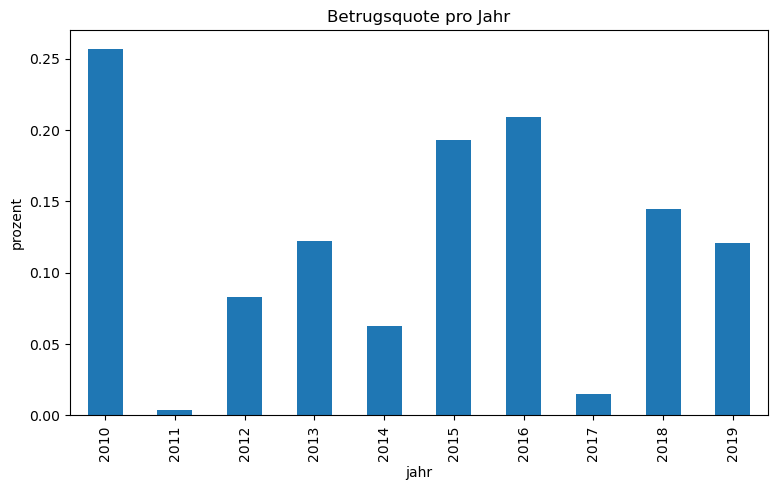

In [24]:
title = 'Betrugsquote pro Jahr'
xlabel = 'jahr'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro Land

In [25]:
sql = """
with
  base(land, is_fraud) as (
    select 
        case
        when length(mstate) = 2 then 'USA'
        else mstate
    end land,
    is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(land, anz_trx, ant_ok, ant_fraud) as (
    select 
      land,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by land
  ),
  ratio(land, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      land,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 6),
      round(ant_fraud*100/anz_trx::numeric, 6)
     from proportion 
  )
select
  land as "land",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where quote_fraud >0
order by land
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('land', inplace = True)
    
data_pdf


,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
land,,,,,
Haiti,403,28,375,6.947891,93.052109
Italy,7583,2901,4682,38.256627,61.743373
Tuvalu,5,0,5,0.000000,100.000000
USA,14479993,14478149,1844,99.987265,0.012735
None,1987649,1974569,13080,99.341936,0.658064


<AxesSubplot: title={'center': 'Betrugsquote pro Land'}, xlabel='land', ylabel='prozent'>

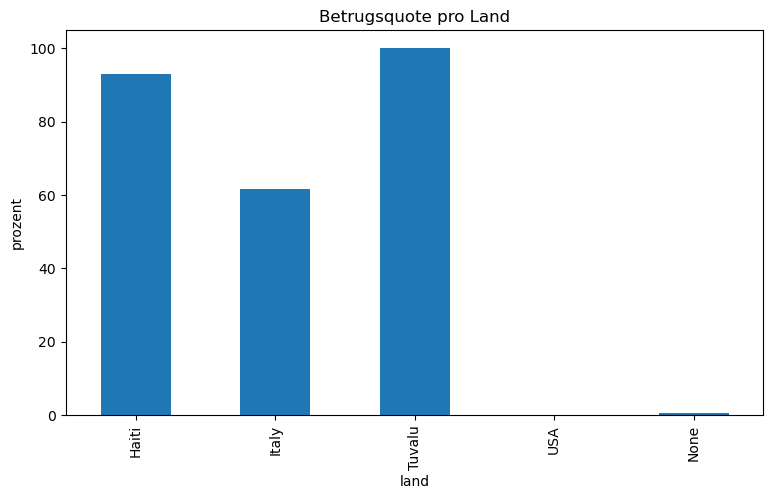

In [26]:
title = 'Betrugsquote pro Land'
xlabel = 'land'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro err1

In [27]:
sql ="""
with
  base(err1, is_fraud) as (
    select 
      err1,
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(err1, anz_trx, ant_ok, ant_fraud) as (
    select 
      err1,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by err1
  ),
  ratio(err1, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      err1,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  err1 as "err1",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where quote_fraud != 0
order by err1;"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('err1', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
err1,,,,,
Bad Card Number,10066,9984,82,99.1854,0.8146
Bad CVV,7851,7648,203,97.4143,2.5857
Bad Expiration,7954,7872,82,98.9691,1.0309
Bad PIN,40172,39997,175,99.5644,0.4356
Insufficient Balance,162029,161764,265,99.8364,0.1636
Technical Glitch,32893,32852,41,99.8754,0.1246
None,16312669,16293531,19138,99.8827,0.1173


<AxesSubplot: title={'center': 'Betrugsquote pro err1'}, xlabel='err1', ylabel='prozent'>

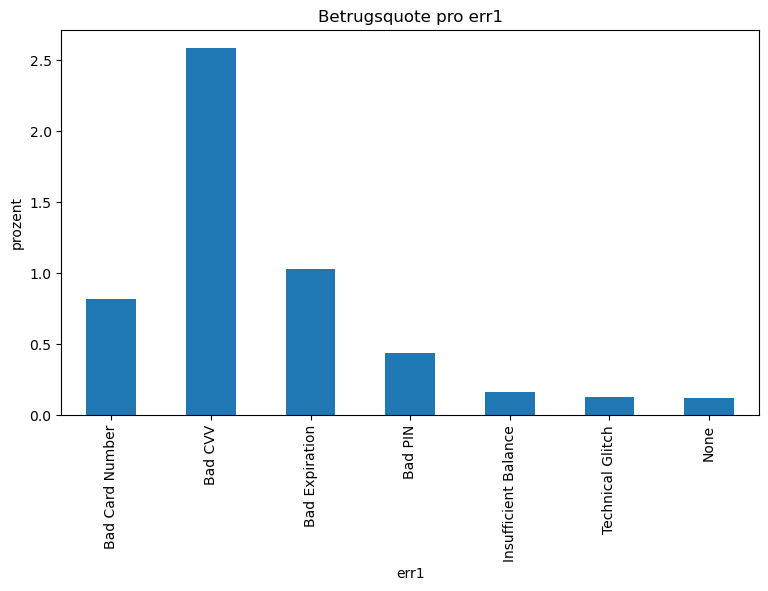

In [28]:
title = 'Betrugsquote pro err1'
xlabel = 'err1'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

### Analysieren den Betrugsanteil pro use_chip

In [29]:
sql = """
with
  base(use_chip, is_fraud) as (
    select 
      use_chip,
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(use_chip, anz_trx, ant_ok, ant_fraud) as (
    select 
      use_chip,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by use_chip 
  ),
  ratio(use_chip, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      use_chip,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  use_chip as "use_chip",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
order by use_chip ;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('use_chip', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
use_chip,,,,,
Chip Transaction,6051735,6046899,4836,99.9201,0.0799
Online Transaction,1980302,1967222,13080,99.3395,0.6605
Swipe Transaction,8543036,8540966,2070,99.9758,0.0242


<AxesSubplot: title={'center': 'Betrugsquote pro use_chip'}, xlabel='use_chip', ylabel='prozent'>

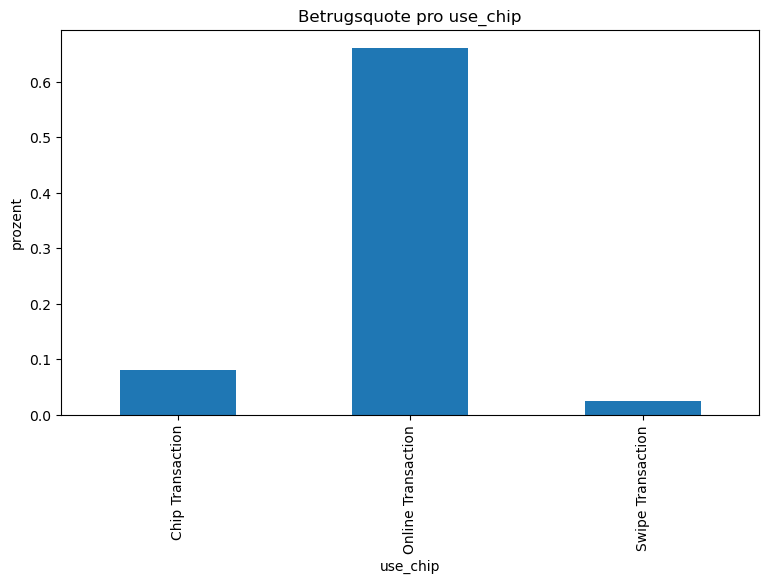

In [30]:
title = 'Betrugsquote pro use_chip'
xlabel = 'use_chip'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

### Analysieren den Betrugsanteil pro Umsatzbereich

In [31]:
sql ="""
with
  base(rank_betrag, is_fraud) as (
    select 
      case when amount < 0 then 'R1'
  	   when amount between 0 and 1000 then 'R2'
  	   when amount between 1001 and 2000 then 'R3'
  	   when amount between 2001 and 3000 then 'R4'
  	   when amount between 3001 and 4000 then 'R5'
  	   when amount between 4001 and 5000 then 'R6'
  	   when amount between 5001 and 6000 then 'R7'
  	else 'R8'
  	end as rank_betrag,
      --round(amount::numeric ,4),
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(rank_betrag, anz_trx, ant_ok, ant_fraud) as (
    select 
      rank_betrag,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by rank_betrag
  ),
  ratio(rank_betrag, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      rank_betrag,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion
  )
  
 select rank_betrag, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud
 from ratio;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('rank_betrag', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
rank_betrag,,,,,
R1,811813,811086,727,99.9104,0.0896
R2,15752029,15732928,19101,99.8787,0.1213
R3,10794,10679,115,98.9346,1.0654
R4,315,282,33,89.5238,10.4762
R5,61,55,6,90.1639,9.8361
R6,19,17,2,89.4737,10.5263
R7,9,8,1,88.8889,11.1111
R8,33,32,1,96.9697,3.0303


<AxesSubplot: title={'center': 'Betrugsquote pro Umsatzbereich'}, xlabel='Umsatzbereich', ylabel='prozent'>

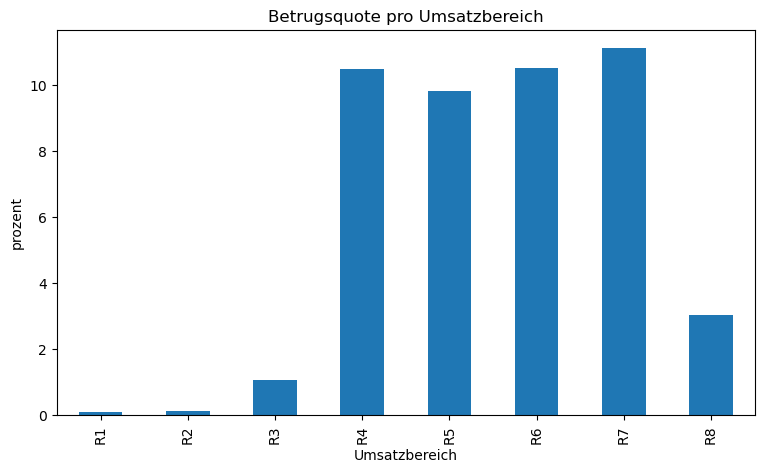

In [32]:
title = 'Betrugsquote pro Umsatzbereich'
xlabel = 'Umsatzbereich'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro Unternehmen

In [33]:
sql ="""
with
  base(unternehmen, is_fraud) as (
    select 
      mname,
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(unternehmen, anz_trx, ant_ok, ant_fraud) as (
    select 
      unternehmen,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by unternehmen
  ),
  ratio(unternehmen, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      unternehmen,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  unternehmen as "unternehmen",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where ant_fraud > 50 and quote_fraud > 10.0
order by unternehmen;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('unternehmen', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
unternehmen,,,,,
-8830141029664022553,82,7,75,8.5366,91.4634
-8804513634474593447,75,1,74,1.3333,98.6667
-7518699381024305844,190,104,86,54.7368,45.2632
-7421991366943579652,94,41,53,43.6170,56.3830
-3362831192073574065,145,70,75,48.2759,51.7241
-2072851135875924699,98,37,61,37.7551,62.2449
-1642303950890406395,443,208,235,46.9526,53.0474
-1615166983578079078,60,0,60,0.0000,100.0000
-1396821880537214279,93,30,63,32.2581,67.7419


<AxesSubplot: title={'center': 'Betrugsquote pro Unternehmen'}, xlabel='unternehmen', ylabel='prozent'>

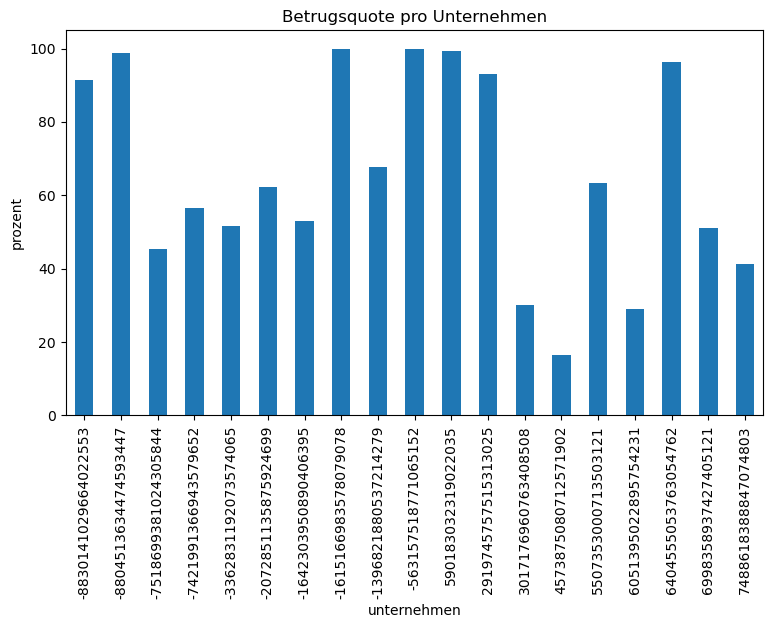

In [35]:
title = 'Betrugsquote pro Unternehmen'
xlabel = 'unternehmen'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(9,5), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro mcc

In [36]:
sql ="""
with
  base(mcc, is_fraud) as (
    select 
      mcc,
      is_fraud
    from uccfraud.ccfraud2010
  ),
  proportion(mcc, anz_trx, ant_ok, ant_fraud) as (
    select 
      mcc,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base
    group by mcc
  ),
  ratio(mcc, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      mcc,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  mcc as "mcc",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where quote_fraud > 0
order by mcc;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('mcc', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
mcc,,,,,
3000,3764,3710,54,98.5654,1.4346
3001,3799,3764,35,99.0787,0.9213
3005,482,448,34,92.9461,7.0539
3006,434,395,39,91.0138,8.9862
3007,443,417,26,94.1309,5.8691
...,...,...,...,...,...
8043,20923,20909,14,99.9331,0.0669
8049,13188,13187,1,99.9924,0.0076
8062,4525,4511,14,99.6906,0.3094


<AxesSubplot: title={'center': 'Betrugsquote pro mcc'}, xlabel='mcc', ylabel='prozent'>

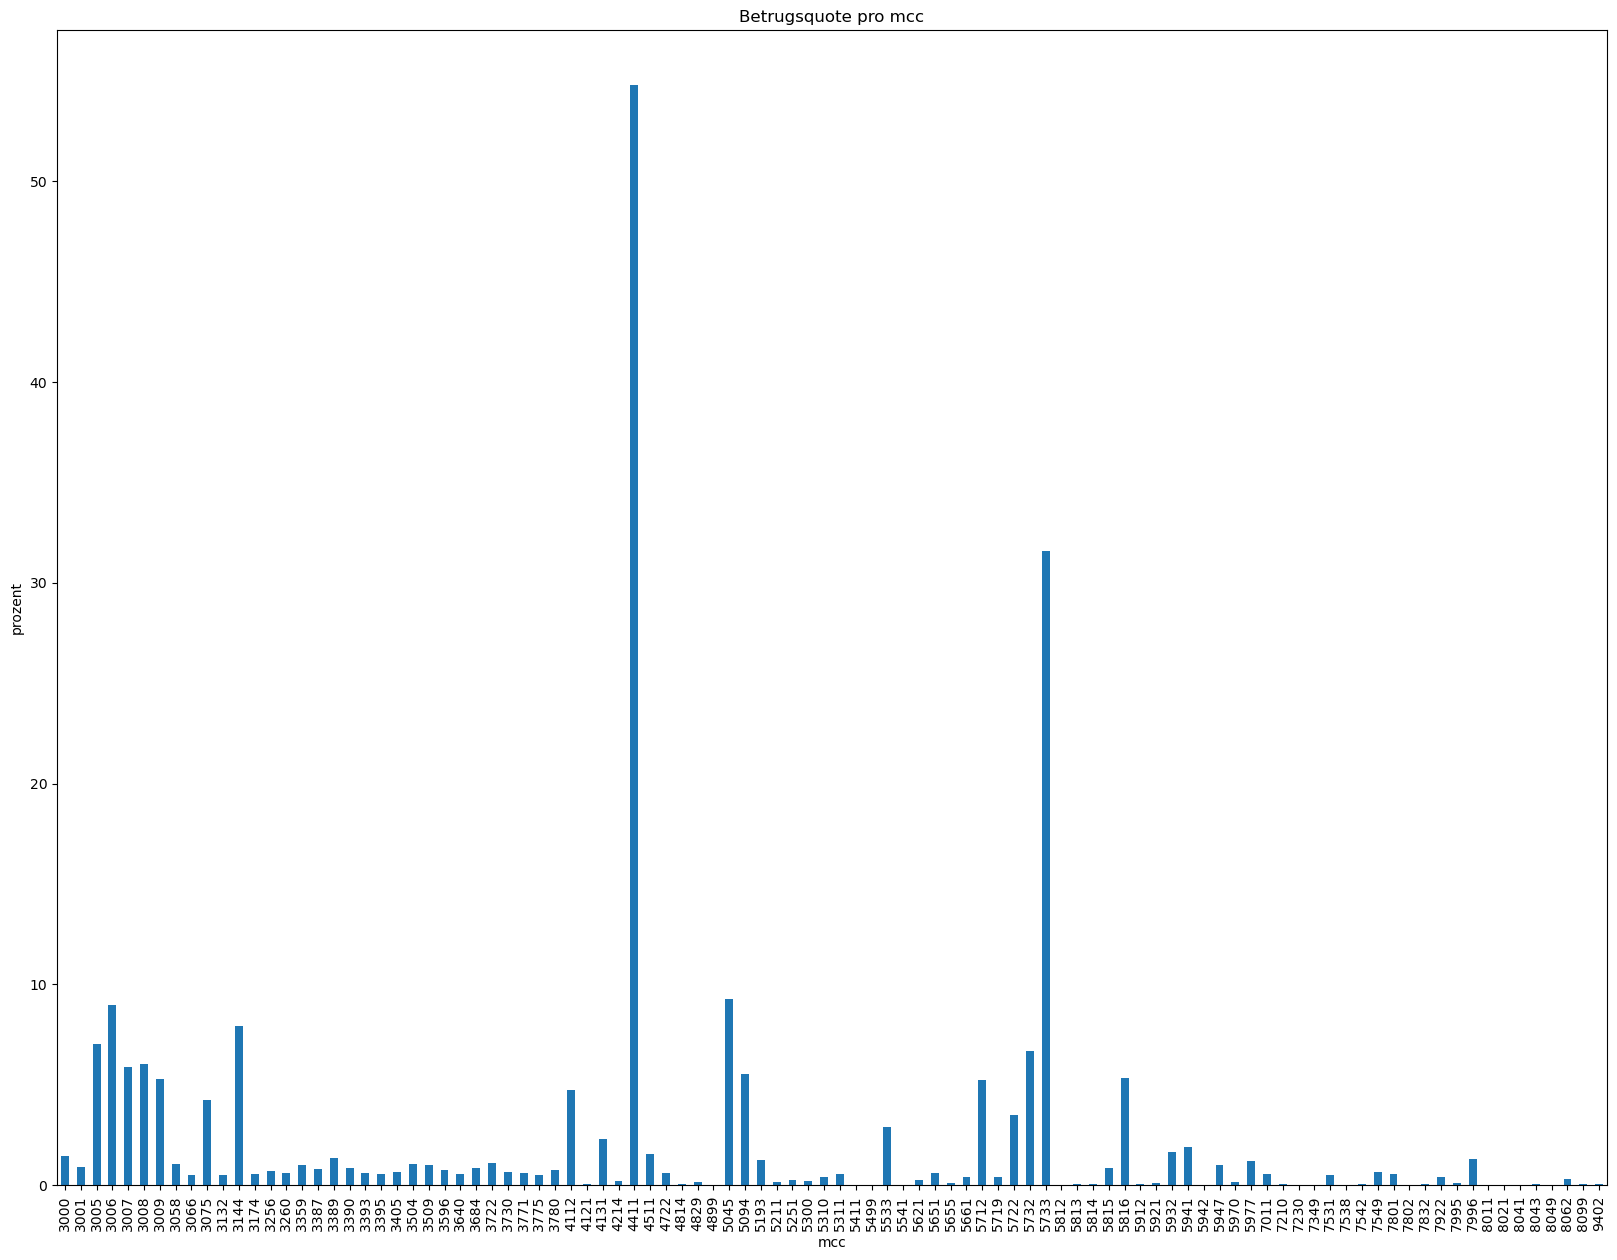

In [40]:
title = 'Betrugsquote pro mcc'
xlabel = 'mcc'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(20,15), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro Zeitbereich - kleiner als 5 min

In [41]:
sql ="""
with 
	base(userid, mname, mcity, ts, ein_ts_vorher, zeit_abstand, is_fraud) as (
		select userid, mname, mcity, ts,
	   --count(*) as anz,
	   lag(ts) over(partition by userid, mname, mcity order by ts) as ein_ts_vorher,
	   ts - (lag(ts) over(partition by userid, mname, mcity order by ts)) as zeit_abstand,
	   is_fraud
		from uccfraud.ccfraud2010 c
		--where ts - (lag(ts) over(partition by userid, mname, mcity order by ts)) < '00:05:00'
		order by ts desc
	),
	base2(userid, mname, mcity, ts, ein_ts_vorher, zeit_abstand, is_fraud) as (
		select *
		from base
		where zeit_abstand < '00:05:00'
		--order by ts desc
	),
	proportion(userid, anz_trx, ant_ok, ant_fraud) as (
    select 
      userid,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base2
    group by userid
  ),
	ratio(userid, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      userid,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  userid as "userid",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where quote_fraud > 0
order by userid;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('userid', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
userid,,,,,
2,379,378,1,99.7361,0.2639
13,167,166,1,99.4012,0.5988
29,473,472,1,99.7886,0.2114
40,306,305,1,99.6732,0.3268
44,504,503,1,99.8016,0.1984
...,...,...,...,...,...
1962,471,470,1,99.7877,0.2123
1963,355,354,1,99.7183,0.2817
1990,315,314,1,99.6825,0.3175


<AxesSubplot: title={'center': 'Betrugsquote pro Zeitbereich'}, xlabel='mcc', ylabel='prozent'>

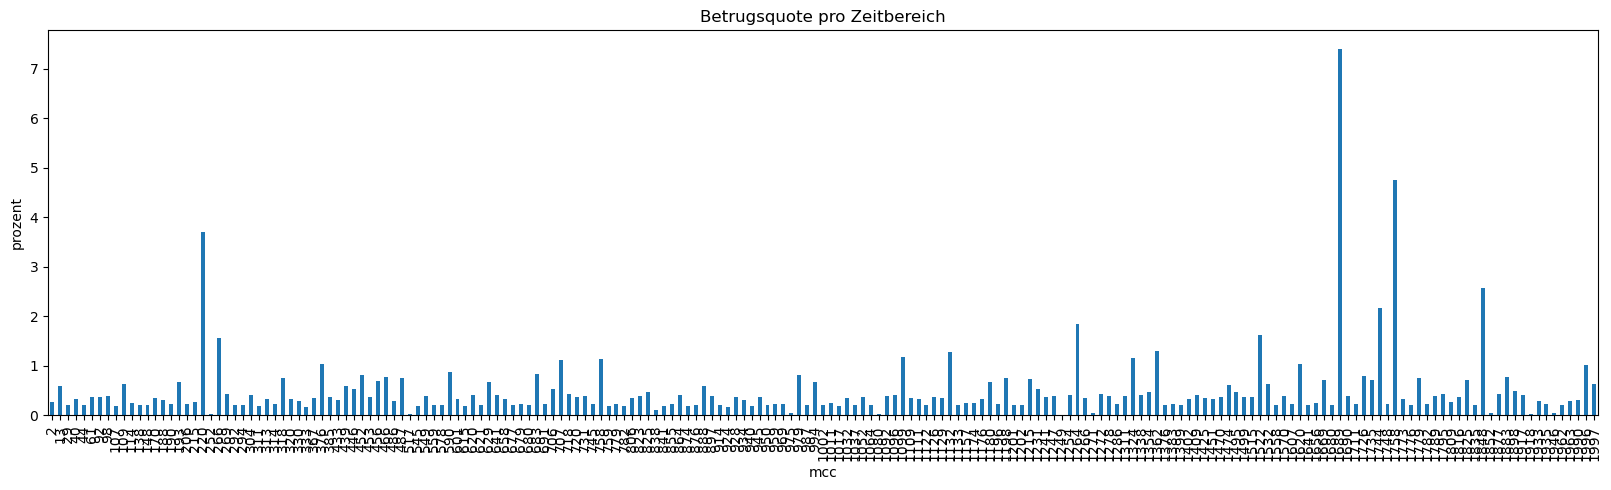

In [47]:
title = 'Betrugsquote pro Zeitbereich'
xlabel = 'mcc'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(20,5), title=title, xlabel=xlabel, ylabel=ylabel)

## Analysieren den Betrugsanteil pro Zeitbereich - größer als 5 min

In [48]:
sql ="""
with 
	base(userid, mname, mcity, ts, ein_ts_vorher, zeit_abstand, is_fraud) as (
		select userid, mname, mcity, ts,
	   --count(*) as anz,
	   lag(ts) over(partition by userid, mname, mcity order by ts) as ein_ts_vorher,
	   ts - (lag(ts) over(partition by userid, mname, mcity order by ts)) as zeit_abstand,
	   is_fraud
		from uccfraud.ccfraud2010 c
		--where ts - (lag(ts) over(partition by userid, mname, mcity order by ts)) < '00:05:00'
		order by ts desc
	),
	base2(userid, mname, mcity, ts, ein_ts_vorher, zeit_abstand, is_fraud) as (
		select *
		from base
		where zeit_abstand >= '00:05:00'
		--order by ts desc
	),
	proportion(userid, anz_trx, ant_ok, ant_fraud) as (
    select 
      userid,
      count(*),
      sum(case when is_fraud='No' then 1 else 0 end),
      sum(case when is_fraud='Yes' then 1 else 0 end)
    from base2
    group by userid
  ),
	ratio(userid, anz_trx, ant_ok, ant_fraud, quote_ok, quote_fraud) as (
    select 
      userid,
      anz_trx, 
      ant_ok, 
      ant_fraud,
      round(ant_ok*100/anz_trx::numeric, 4),
      round(ant_fraud*100/anz_trx::numeric, 4)
     from proportion 
  )
select
  userid as "userid",
  anz_trx as "anz_trx",
  ant_ok as "ant_ok",
  ant_fraud as "ant_fraud",
  quote_ok as "quote_ok",
  quote_fraud as "quote_fraud"
from ratio
where quote_fraud > 0
order by userid;
"""

with engine.connect() as con:
    data_pdf = pd.read_sql_query(sql, con)
    data_pdf.set_index('userid', inplace = True)
    
data_pdf

,anz_trx,ant_ok,ant_fraud,quote_ok,quote_fraud
userid,,,,,
0,10539,10536,3,99.9715,0.0285
1,5032,5030,2,99.9603,0.0397
2,25006,24990,16,99.9360,0.0640
3,7338,7334,4,99.9455,0.0545
5,11675,11671,4,99.9657,0.0343
...,...,...,...,...,...
1990,13247,13244,3,99.9774,0.0226
1993,4544,4538,6,99.8680,0.1320
1995,10941,10938,3,99.9726,0.0274


<AxesSubplot: title={'center': 'Betrugsquote pro Zeitbereich'}, xlabel='mcc', ylabel='prozent'>

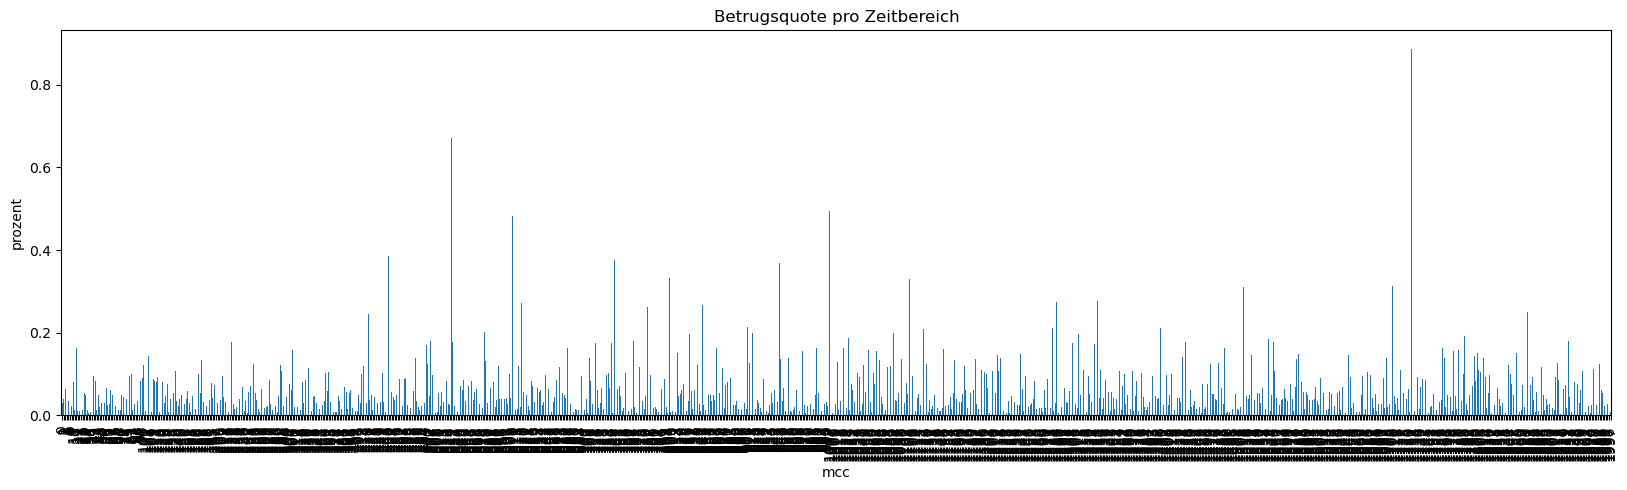

In [52]:
title = 'Betrugsquote pro Zeitbereich'
xlabel = 'mcc'
ylabel='prozent'
data_pdf['quote_fraud'].plot.bar(figsize=(20,5), title=title, xlabel=xlabel, ylabel=ylabel)